In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, activations
from tensorflow_addons.layers import SpectralNormalization

from models import NVAE
from datasets import load_coco
from helper_functions2 import make_img, plot_loss3, plot_loss7, draw3, make_gallery, draw2

In [4]:
image_shape = 128
use_all_data = False
latent_dim = 32

max_epoch = 500                 # Max Epochs
batch_size = 100                 # Batch size
lr = 0.0001                      # Initial learning rate

n_encoder_channels = 16         # Number of initial channels in encoder
n_decoder_channels = 16         # Number of initial channels in decoder

res_cells_per_group = 2         # Number of residual cells to use within each group

n_preprocess_blocks = 2         # Number of blocks to use in the preprocessing layers
n_preprocess_cells = 3          # Number of cells to use within each preprocessing block

n_postprocess_blocks = 2        # Number of blocks to use in the postprocessing layers
n_postprocess_cells = 3         # Number of cells to use within each postprocessing block

n_latent_per_group = 20         # Number of latent stochastic variables to sample in each group
n_groups_per_scale = [5, 10]    # Number of groups to include in each resolution scale

sr_lambda = 0.01                 # Spectral regularisation strength
scale_factor = 2                # Factor to rescale image with in each scaling step
step_based_warmup = False       # Base warmup on batches trained instead of epochs

use_multigpu = False
drop_remain = False
dataset = 'coco'

In [5]:
if use_multigpu:
    strategy = tf.distribute.MirroredStrategy()
    print ('\nNumber of devices: {}'.format(strategy.num_replicas_in_sync), flush=True)

    GLOBAL_BATCH_SIZE = batch_size * strategy.num_replicas_in_sync
    train_data, val_data, test_data, train_imgs_len = load_coco(use_all_data, image_shape, batch_size, drop_remain)
    batches_per_epoch = ((train_imgs_len + batch_size - 1) // batch_size) * strategy.num_replicas_in_sync
else:
    train_data, val_data, test_data, train_imgs_len = load_coco(use_all_data, image_shape, batch_size, drop_remain)
    batches_per_epoch = (train_imgs_len + batch_size - 1) // batch_size
    GLOBAL_BATCH_SIZE = batch_size

/users/apokkunu/trial/img/annotations/captions_train2014.json /users/apokkunu/trial/img/train2014/

dataset size: 82783

temp dataset size: 100
/users/apokkunu/trial/img/annotations/captions_val2014.json /users/apokkunu/trial/img/val2014/

dataset size: 40504

temp dataset size: 100
/users/apokkunu/trial/img/annotations/image_info_test2014.json /users/apokkunu/trial/img/test2014/

dataset size: 40775

temp dataset size: 100

dataset size: 100

dataset size: 100

dataset size: 100


In [6]:
def checkpoint_path(model_save_dir, epoch):
    return os.path.join(model_save_dir, f"epoch_{epoch}")

In [7]:
model = NVAE(n_encoder_channels=n_encoder_channels,
                     n_decoder_channels=n_decoder_channels,
                     res_cells_per_group=res_cells_per_group,
                     n_preprocess_blocks=n_preprocess_blocks,
                     n_preprocess_cells=n_preprocess_cells,
                     n_postprocess_blocks=n_postprocess_blocks,
                     n_post_process_cells=n_postprocess_cells,
                     n_latent_per_group=n_latent_per_group,
                     n_latent_scales=len(n_groups_per_scale),
                     n_groups_per_scale=n_groups_per_scale,
                     sr_lambda=sr_lambda,
                     scale_factor=scale_factor,
                     total_epochs=max_epoch,
                     n_total_iterations=batches_per_epoch * max_epoch,  # for balance kl
                     step_based_warmup=step_based_warmup,
                     input_shape=tf.convert_to_tensor([batch_size, 128, 128, 3], dtype=float),
                     dataset_option=dataset,
                     use_multigpu=use_multigpu,
                     GLOBAL_BATCH_SIZE=GLOBAL_BATCH_SIZE)

model.build(input_shape=(batch_size, 128, 128, 3))
model.trainable = False
model.summary()

model_save_dir = '/users/apokkunu/trial/img/nvae-tf/trial_2/models_coco/'
epoch = 95
model.load_weights(checkpoint_path(model_save_dir, epoch))

Model: "nvae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocess (Preprocess)      multiple                  122280    
_________________________________________________________________
encoder (Encoder)            multiple                  6985160   
_________________________________________________________________
decoder (Decoder)            multiple                  5661768   
_________________________________________________________________
postprocess (Postprocess)    multiple                  3574976   
Total params: 16,344,184
Trainable params: 0
Non-trainable params: 16,344,184
_________________________________________________________________


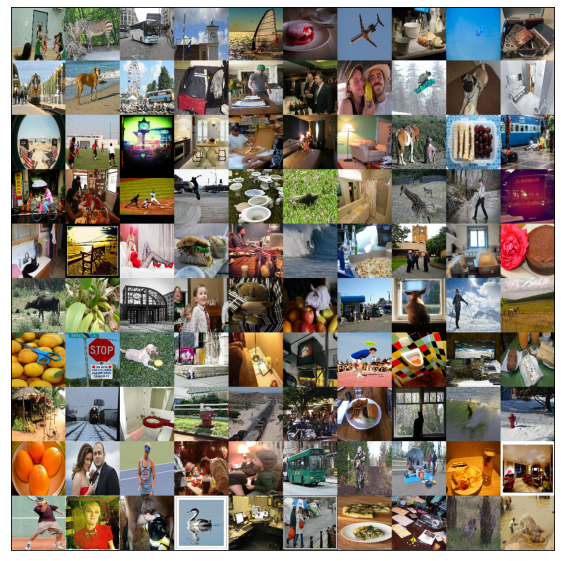

In [9]:
batch = tf.convert_to_tensor(next(test_data.shuffle(buffer_size=1000).as_numpy_iterator()))

reconstruction_logits, z_params, *_ = model(batch)
images = model.sample_from_discretized_mix_logistic(reconstruction_logits)

color_mode = True
save = False
save_path = './'

make_gallery(batch.numpy(), 10, epoch, 'orig', color_mode, save_path, save)

In [2]:
class SqueezeExcitation(tf.keras.Model):
    """Squeeze and Excitation block as defined by Hu, et al. (2019)
    See Also
    ========
    Source paper https://arxiv.org/pdf/1709.01507.pdf
    """
    def __init__(self, ratio=16, **kwargs) -> None:
        super().__init__(**kwargs)
        self.ratio = ratio

    def build(self, input_shape):
        batch_size, h, w, c = input_shape
        self.gap = layers.GlobalAveragePooling2D(data_format="channels_last")
        num_hidden = max(c / self.ratio, 4)
        self.dense1 = layers.Dense(units=num_hidden)
        self.dense2 = layers.Dense(units=c)

    def call(self, inputs):
        x = self.gap(inputs)
        x = self.dense1(x)
        x = activations.relu(x)
        x = self.dense2(x)
        x = activations.sigmoid(x)
        x = tf.expand_dims(x, 1)
        x = tf.expand_dims(x, 2)
        return x * inputs

class ResidualBlockA(tf.keras.Model):
    """residual cell A"""
    def __init__(self, output_channels, **kwargs):
        super().__init__(**kwargs)
        self.batch_norm1 = layers.BatchNormalization(momentum=0.05, epsilon=1e-5)
        self.conv1 = SpectralNormalization(layers.Conv2D(output_channels, (3, 3), padding="same"))
        self.batch_norm2 = layers.BatchNormalization(momentum=0.05, epsilon=1e-5)
        self.conv2 = SpectralNormalization(layers.Conv2D(output_channels, (3, 3), padding="same"))
        self.se = SqueezeExcitation()
    
    def call(self, inputs):
        x = activations.swish(self.batch_norm1(inputs))
        x = self.conv1(x)
        x = activations.swish(self.batch_norm2(x))
        x = self.conv2(x)
        x = self.se(x)
        return inputs + x
    
    
class ResidualBlockB(tf.keras.Model):
    """residual cell B"""
    def __init__(self, output_channels, **kwargs):
        super().__init__(**kwargs)
        self.conv0 = SpectralNormalization(layers.Conv2D(2 * output_channels, (1, 1), strides=(2, 2), padding="same"))
        self.batch_norm1 = layers.BatchNormalization(momentum=0.05, epsilon=1e-5)
        self.conv1 = SpectralNormalization(layers.Conv2D(2 * output_channels, (3, 3), strides=(2, 2), padding="same"))
        self.batch_norm2 = layers.BatchNormalization(momentum=0.05, epsilon=1e-5)
        self.conv2 = SpectralNormalization(layers.Conv2D(2 * output_channels, (3, 3), strides=(1, 1), padding="same"))
        self.se = SqueezeExcitation()
    
    def call(self, inputs):
        x_in = activations.swish(inputs)
        x_in = self.conv0(x_in)
        x = activations.swish(self.batch_norm1(inputs))
        x = self.conv1(x)
        x = activations.swish(self.batch_norm2(x))
        x = self.conv2(x)
        x = self.se(x)
        return x_in + x

In [14]:
def create_ebm_model(output_channels, n_latent_per_group, model_num):
    latent_in = layers.Input(shape=(output_channels, output_channels, n_latent_per_group))
    x = SpectralNormalization(layers.Conv2D(output_channels, (3, 3), padding="same"))(latent_in)
    x = layers.Activation('relu')(x)
    x = ResidualBlockA(output_channels)(x)
    x = ResidualBlockA(output_channels)(x)
    x = ResidualBlockA(output_channels)(x)
    
    x = ResidualBlockB(output_channels)(x)

    x = ResidualBlockA(2 * output_channels)(x)
    x = ResidualBlockA(2 * output_channels)(x)
    x = ResidualBlockA(2 * output_channels)(x)

    x = ResidualBlockB(2 * output_channels)(x)

    x = layers.GlobalAveragePooling2D()(x)
    energy_vals = layers.Dense(1)(x)
    ebm = tf.keras.Model(latent_in, energy_vals, name="EBM_" + str(model_num))
    ebm.summary()
    return ebm

output_channels = 16
ebm1 = create_ebm_model(output_channels, n_latent_per_group, 1)

output_channels = 16
ebm2 = create_ebm_model(output_channels, n_latent_per_group, 2)

output_channels = 16
ebm3 = create_ebm_model(output_channels, n_latent_per_group, 3)

output_channels = 16
ebm4 = create_ebm_model(output_channels, n_latent_per_group, 4)

output_channels = 16
ebm5 = create_ebm_model(output_channels, n_latent_per_group, 5)

output_channels = 16
ebm6 = create_ebm_model(output_channels, n_latent_per_group, 6)

output_channels = 16
ebm7 = create_ebm_model(output_channels, n_latent_per_group, 7)

output_channels = 16
ebm8 = create_ebm_model(output_channels, n_latent_per_group, 8)

output_channels = 16
ebm9 = create_ebm_model(output_channels, n_latent_per_group, 9)

output_channels = 16
ebm10 = create_ebm_model(output_channels, n_latent_per_group, 10)

###################

output_channels = 32
ebm11 = create_ebm_model(output_channels, n_latent_per_group, 11)

output_channels = 32
ebm11 = create_ebm_model(output_channels, n_latent_per_group, 12)

output_channels = 32
ebm11 = create_ebm_model(output_channels, n_latent_per_group, 13)

output_channels = 32
ebm11 = create_ebm_model(output_channels, n_latent_per_group, 14)

output_channels = 32
ebm11 = create_ebm_model(output_channels, n_latent_per_group, 15)

Model: "EBM_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 16, 16, 20)]      0         
_________________________________________________________________
spectral_normalization_538 ( (None, 16, 16, 16)        2912      
_________________________________________________________________
activation_41 (Activation)   (None, 16, 16, 16)        0         
_________________________________________________________________
residual_block_a_102 (Residu (None, 16, 16, 16)        4948      
_________________________________________________________________
residual_block_a_103 (Residu (None, 16, 16, 16)        4948      
_________________________________________________________________
residual_block_a_104 (Residu (None, 16, 16, 16)        4948      
_________________________________________________________________
residual_block_b_34 (Residua (None, 8, 8, 32)          15012 

In [7]:
def compute_gradient(model, z):
    with tf.GradientTape() as tape:
        tape.watch(z)
        energy = model(z) + 0.5 * tf.reduce_sum(tf.pow(z,2), axis=1)
    return tape.gradient(energy, z), energy

def langevin_inf(model, z, orig_z, inf_iter, inf_rate, eta, mode, step, epoch):
    current_z = z
    
    if mode == 'val':
        z_arr = [current_z]
    
    for i in range(inf_iter):
        gradients, energy = compute_gradient(model, current_z)
        
        # Langevin dynamics
        term1 = 0.5 * inf_rate * gradients
        term2 = eta * tf.random.normal(current_z.get_shape().as_list())
        next_z = current_z - term1 + term2
        current_z = tf.clip_by_value(next_z, 0.0, 1.0)
        
        if step % 50 == 0 and epoch % 10 == 0 and mode == 'train':
            template = "LD Step: {}, Avg. MSE: {}, Avg. energy: {}"
            mse = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.mean_squared_error(model_decoder(orig_z), model_decoder(current_z)), axis=(1, 2))).numpy()
            print(template.format(i, mse, tf.reduce_mean(energy).numpy()), flush=True)
        
        if mode == 'val':
            z_arr.append(current_z)
    
    if mode == 'train':
        return current_z
    else:
        return current_z, np.array(z_arr)

In [ ]:
class EBM(Model):
    def __init__(self, ebm1, ebm2, ebm3, ebm4, ebm5, ebm6, ebm7, ebm8, ebm9, ebm10, ebm11, ebm12, ebm13, ebm14, ebm15, optimizer, model):
        super(EBM, self).__init__()
        self.ebm1 = ebm1
        self.ebm2 = ebm2
        self.ebm3 = ebm3
        self.ebm4 = ebm4
        self.ebm5 = ebm5
        self.ebm6 = ebm6
        self.ebm7 = ebm7
        self.ebm8 = ebm8
        self.ebm9 = ebm9
        self.ebm10 = ebm10
        self.ebm11 = ebm11
        self.ebm12 = ebm12
        self.ebm13 = ebm13
        self.ebm14 = ebm14
        self.ebm15 = ebm15
        
        self.model = model
        
        self.optimizer = optimizer
        
        self.train_loss_track = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
        self.val_loss_track = tf.keras.metrics.Mean('val_loss', dtype=tf.float32)
        
        self.re_train = tf.keras.metrics.Mean('re_train', dtype=tf.float32)
        self.lde_train = tf.keras.metrics.Mean('lde_train', dtype=tf.float32)
        
        self.re_val = tf.keras.metrics.Mean('re_val', dtype=tf.float32)
        self.lde_val = tf.keras.metrics.Mean('lde_val', dtype=tf.float32)
        
        self.train_loss_batch = tf.keras.metrics.Mean('train_loss_batch', dtype=tf.float32)
        self.re_batch = tf.keras.metrics.Mean('re_batch', dtype=tf.float32)
        self.lde_batch = tf.keras.metrics.Mean('lde_batch', dtype=tf.float32)
        
    def main_compute(self, mode, z_params, model, model_num):
        z_mean = z_params[model_num].enc_mu
        z_log_var = z_params[model_num].enc_sigma
        
        z_image = z_mean + tf.random.normal(shape=tf.shape(z_mean), dtype=tf.float32) * z_log_var
        z_s = tf.random.normal(z_image.get_shape().as_list())
        
        if mode == 'train':
            with tf.GradientTape() as tape:
                x_pos = model(z_image)
                x_neg = model(z_s)
                part1 = -tf.math.log(tf.nn.sigmoid(-x_pos)) + tf.math.log(tf.nn.sigmoid(-x_neg))
                part2 = l2_reg * (tf.reduce_mean(tf.math.pow(x_pos, 2)) + tf.reduce_mean(tf.math.pow(x_neg, 2)))
                ebm_loss = part1 + part2
            grads = tape.gradient(ebm_loss, model.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, model.trainable_weights))
            
            if model_num == 1:
                ans = tf.reduce_mean(x_pos);        self.re_batch.update_state(ans);          self.re_train.update_state(ans)
                ans = tf.reduce_mean(x_neg);        self.lde_train.update_state(ans);         self.lde_batch.update_state(ans)
                self.train_loss_track.update_state(ebm_loss);        self.train_loss_batch.update_state(ebm_loss)
        else:
            x_pos = model(z_image)
            x_neg = model(z_s)
            part1 = -tf.math.log(tf.nn.sigmoid(-x_pos)) + tf.math.log(tf.nn.sigmoid(-x_neg))
            part2 = l2_reg * (tf.reduce_mean(tf.math.pow(x_pos, 2)) + tf.reduce_mean(tf.math.pow(x_neg, 2)))
            ebm_loss = part1 + part2
            
            if model_num == 1:
                self.re_val.update_state(tf.reduce_mean(x_pos))
                self.lde_val.update_state(tf.reduce_mean(x_neg))
                self.val_loss_track.update_state(ebm_loss)
    
    def compute_loss(self, data, l2_reg, mode):
        reconstruction_logits, z_params, *_ = self.model(data)
        self.main_compute(mode, z_params, self.ebm1, 1)
        self.main_compute(mode, z_params, self.ebm2, 2)
        self.main_compute(mode, z_params, self.ebm3, 3)
        self.main_compute(mode, z_params, self.ebm4, 4)
        self.main_compute(mode, z_params, self.ebm5, 5)
        self.main_compute(mode, z_params, self.ebm6, 6)
        self.main_compute(mode, z_params, self.ebm7, 7)
        self.main_compute(mode, z_params, self.ebm8, 8)
        self.main_compute(mode, z_params, self.ebm9, 9)
        self.main_compute(mode, z_params, self.ebm10, 10)
        self.main_compute(mode, z_params, self.ebm11, 11)
        self.main_compute(mode, z_params, self.ebm12, 12)
        self.main_compute(mode, z_params, self.ebm13, 13)
        self.main_compute(mode, z_params, self.ebm14, 14)
        self.main_compute(mode, z_params, self.ebm15, 15)
        
    def create_test_model(self, z_params, model, model_num, epoch):
        z_mean = z_params[model_num].enc_mu
        z_log_var = z_params[model_num].enc_sigma
        
        z_image = z_mean + tf.random.normal(shape=tf.shape(z_mean), dtype=tf.float32) * z_log_var # actual test z
        z = tf.random.normal(z_image.get_shape().as_list()) # random test z
        
        z_ld, z_rr = langevin_inf(model, z, z_image, inf_iter_val, inf_rate_val, eta, 'val', epoch, epoch)
        return z_image, z_ld, z_rr
    
    def sample_with_z(self, z, s):
        last_gen_layer = self.model.decoder.groups[-1]
        s = last_gen_layer(s, z)
        reconstruction = self.model.postprocess(s)
        
        if self.dataset_option == 'mnist':
            distribution = distributions.Bernoulli(logits=reconstruction, dtype=tf.float32, allow_nan_stats=False)
            images = distribution.mean()
        else:
            images = self.model.sample_from_discretized_mix_logistic(reconstruction)
        return images
    
    def test_ebm(self, data, epoch):
        reconstruction_logits, z_params, *_ = self.model(data)
        
        z_image, z_ld, z_rr = self.create_test_model(z_params, self.ebm1, 1, epoch)
        z_image, z_ld, z_rr = self.create_test_model(z_params, self.ebm2, 2, epoch)
        z_image, z_ld, z_rr = self.create_test_model(z_params, self.ebm3, 3, epoch)
        z_image, z_ld, z_rr = self.create_test_model(z_params, self.ebm4, 4, epoch)
        z_image, z_ld, z_rr = self.create_test_model(z_params, self.ebm5, 5, epoch)
        z_image, z_ld, z_rr = self.create_test_model(z_params, self.ebm6, 6, epoch)
        z_image, z_ld, z_rr = self.create_test_model(z_params, self.ebm7, 7, epoch)
        z_image, z_ld, z_rr = self.create_test_model(z_params, self.ebm8, 8, epoch)
        z_image, z_ld, z_rr = self.create_test_model(z_params, self.ebm9, 9, epoch)
        z_image, z_ld, z_rr = self.create_test_model(z_params, self.ebm10, 10, epoch)
        z_image, z_ld, z_rr = self.create_test_model(z_params, self.ebm11, 11, epoch)
        z_image, z_ld, z_rr = self.create_test_model(z_params, self.ebm12, 12, epoch)
        z_image, z_ld, z_rr = self.create_test_model(z_params, self.ebm13, 13, epoch)
        z_image, z_ld, z_rr = self.create_test_model(z_params, self.ebm14, 14, epoch)
        z_image, z_ld, z_rr = self.create_test_model(z_params, self.ebm15, 15, epoch)
        
        color_mode = False
        name = 'testing_images'
        
        # show results
        sample_with_z(self, z, s)
        
        draw3(data[0], decoded_image_orig[0], decoded_image_ld[0], color_mode, save_path, save, epoch, name)
        
        # ld step wise image all
        img_arr = np.array([self.decoder_image(z_rr[i, :, :latent_dim]).numpy() for i in range(len(z_rr))])
        make_img(img_arr, 10, epoch, color_mode, save_path, save, name)
        
        mse_loss_ld = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.mean_squared_error(data, decoded_image_ld), axis=(1, 2)))
        mse_loss_vae = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.mean_squared_error(data, decoded_image_orig), axis=(1, 2)))
        print('MSE VAE: {}, MSE LD: {}'.format(mse_loss_ld, mse_loss_vae), flush=True)

In [ ]:
opt_ebm = tf.keras.optimizers.Adam(lr)
ebm_model = EBM(ebm_1, ebm_2, opt_ebm, model)


# In[ ]:


print('MAX_EPOCHS: {}, LR: {}, BS: {}, Z_DIM: {}, IMG_S: {}'.format(max_epoch, lr, batch_size, latent_dim, image_shape[0]), flush=True)
print('Inf Rate Test: {}, Inf Iter Test: {}'.format(inf_rate_val, inf_iter_val), flush=True)
print('Eta: {}, L2 Reg: {}'.format(eta, l2_reg), flush=True)


# In[ ]:


train_loss = []; val_loss = []
re_energy_tr = []; ld_energy_tr = []
re_energy_val = []; ld_energy_val = []
epoch = 0

while epoch < max_epoch:
    print("\nEpoch:", epoch, flush=True)
    start = timer()

    print('Training EBM', flush=True)
    for re_image in train_dataset:
        ebm_model.compute_loss(re_image, l2_reg, 'train')
        
        if epoch % 20 == 0:
            template = "Loss Batch: {}, E_POS Batch: {}, E_NEG Batch: {}"
            print(template.format(ebm_model.train_loss_batch.result(), ebm_model.re_batch.result(), ebm_model.lde_batch.result()), flush=True)
        
        ebm_model.re_batch.reset_states()
        ebm_model.lde_batch.reset_states()
        ebm_model.train_loss_batch.reset_states()
        tf.keras.backend.clear_session()
        gc.collect()
    
    print('Validating EBM', flush=True)
    for re_image in test_dataset:
        ebm_model.compute_loss(re_image, l2_reg, 'val')
        tf.keras.backend.clear_session()
        gc.collect()
    
    train_loss.append(ebm_model.train_loss_track.result());    val_loss.append(ebm_model.val_loss_track.result())
    re_energy_tr.append(ebm_model.re_train.result());          ld_energy_tr.append(ebm_model.lde_train.result())
    re_energy_val.append(ebm_model.re_val.result());           ld_energy_val.append(ebm_model.lde_val.result())

    if epoch % 20 == 0:
        if epoch > 0:
            plot_loss3(epoch, train_loss, val_loss, 'Loss', save_path, save)
            plot_loss7(epoch, re_energy_tr, ld_energy_tr, re_energy_val, ld_energy_val, 'Energy', save_path, save, 'epos_tr', 'eneg_tr', 'epos_val', 'eneg_val')
            ebm.save_weights(save_path + 'ebm_' + str(epoch) + '.h5')

        for re_image in test_dataset.take(1):
            print('Example Image generation', flush=True)
            ebm_model.test_ebm(re_image, epoch)
            tf.keras.backend.clear_session()
            gc.collect()
    
    with train_summary_writer.as_default():
        tf.summary.scalar('Train Loss', ebm_model.train_loss_track.result(), step=epoch)
        tf.summary.scalar('E_POS Train', ebm_model.re_train.result(), step=epoch)
        tf.summary.scalar('E_NEG Train', ebm_model.lde_train.result(), step=epoch)
    
    with val_summary_writer.as_default():
        tf.summary.scalar('Val Loss', ebm_model.val_loss_track.result(), step=epoch)
        tf.summary.scalar('E_POS Train', ebm_model.re_val.result(), step=epoch)
        tf.summary.scalar('E_NEG Train', ebm_model.lde_val.result(), step=epoch)
    
    print("Train Loss: {}, Val Loss: {}".format(ebm_model.train_loss_track.result(), ebm_model.val_loss_track.result()), flush=True)
    print("E_POS Train: {}, E_NEG Train: {}".format(ebm_model.re_train.result(), ebm_model.lde_train.result()), flush=True)
    print("E_POS Val: {}, E_NEG Val: {}".format(ebm_model.re_val.result(), ebm_model.lde_val.result()), flush=True)
    
    ebm_model.train_loss_track.reset_states();    ebm_model.val_loss_track.reset_states()
    ebm_model.re_train.reset_states();            ebm_model.lde_train.reset_states()
    ebm_model.re_val.reset_states();              ebm_model.lde_val.reset_states()

    epoch += 1
    
    tf.keras.backend.clear_session()
    gc.collect()
    
    end = timer()
    print('Loop Time: ', end - start, 'secs', flush=True)
    del start, end
        
        
# final epoch
plot_loss3(epoch-1, train_loss, val_loss, 'Loss_final', save_path, save)
plot_loss7(epoch-1, re_energy_tr, ld_energy_tr, re_energy_val, ld_energy_val, 'Energy_final', save_path, save, 'epos_tr', 'eneg_tr', 'epos_val', 'eneg_val')
ebm.save_weights(save_path + 'ebm_final_' + str(epoch) + '.h5')

for re_image in test_dataset.take(1):
    ebm_model.test_ebm(re_image, epoch)
    tf.keras.backend.clear_session()
    gc.collect()